# Three-Point Percentage Prediction Model

**Goal: Predict each player’s three-point percentage at the end of the 2022-23 season given their shooting  statistics from October/November 2022**

Notes & Assumptions:
1. Only using data from the csv file provided (subset of 108 players)
2. Dataset excludes some shot locations and does not perfectly match 2022-23 official NBA stats


In [1]:
# Import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## Initial Data Inspection and Exploration

In [2]:
# Import the data
df = pd.read_csv("fas_2024.csv")

# Preview the data
df.head()

,Name,three_pct_season,lwr_paint_pct_oct_nov,upr_paint_pct_oct_nov,mid_pct_oct_nov,three_non_cnr_pct_oct_nov,three_cnr_pct_oct_nov,ft_pct_oct_nov,lwr_paint_shots_oct_nov,upr_paint_shots_oct_nov,mid_shots_oct_nov,three_non_cnr_shots_oct_nov,three_cnr_shots_oct_nov,ft_shots_oct_nov
0,Malcolm Brogdon,0.437,0.484,0.619,0.600,0.444,0.485,0.863,62,21,10,27,33,51
1,Tyrese Maxey,0.435,0.505,0.452,0.458,0.512,0.361,0.738,105,42,24,41,61,65
2,Stephen Curry,0.432,0.706,0.526,0.467,0.415,0.466,0.907,109,38,30,82,148,107
3,Kentavious Caldwell-Pope,0.422,0.484,0.250,0.448,0.512,0.476,0.767,31,16,29,43,42,30
4,Jevon Carter,0.421,0.483,0.375,0.500,0.321,0.480,0.846,29,16,32,28,50,13


In [3]:
# Ensure there are no missing values in the data 
df.info()

# Ensure there is only 1 row per player 
df['Name'].value_counts().sort_values(ascending=False)

# Ensure there are 108 rows (1 per player), and 14 columns (12 independent variables, 1 dependent variable, 1 player name)
print("rows:",df.shape[0])
print("columns:",df.shape[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Name                         108 non-null    object 
 1   three_pct_season             108 non-null    float64
 2   lwr_paint_pct_oct_nov        108 non-null    float64
 3   upr_paint_pct_oct_nov        108 non-null    float64
 4   mid_pct_oct_nov              108 non-null    float64
 5   three_non_cnr_pct_oct_nov    108 non-null    float64
 6   three_cnr_pct_oct_nov        108 non-null    float64
 7   ft_pct_oct_nov               108 non-null    float64
 8   lwr_paint_shots_oct_nov      108 non-null    int64  
 9   upr_paint_shots_oct_nov      108 non-null    int64  
 10  mid_shots_oct_nov            108 non-null    int64  
 11  three_non_cnr_shots_oct_nov  108 non-null    int64  
 12  three_cnr_shots_oct_nov      108 non-null    int64  
 13  ft_shots_oct_nov    

## Exploratory Data Analysis

Before getting into modeling, we want to get a sense of the data we are working with, identify trends, understand relationships between variables, etc.

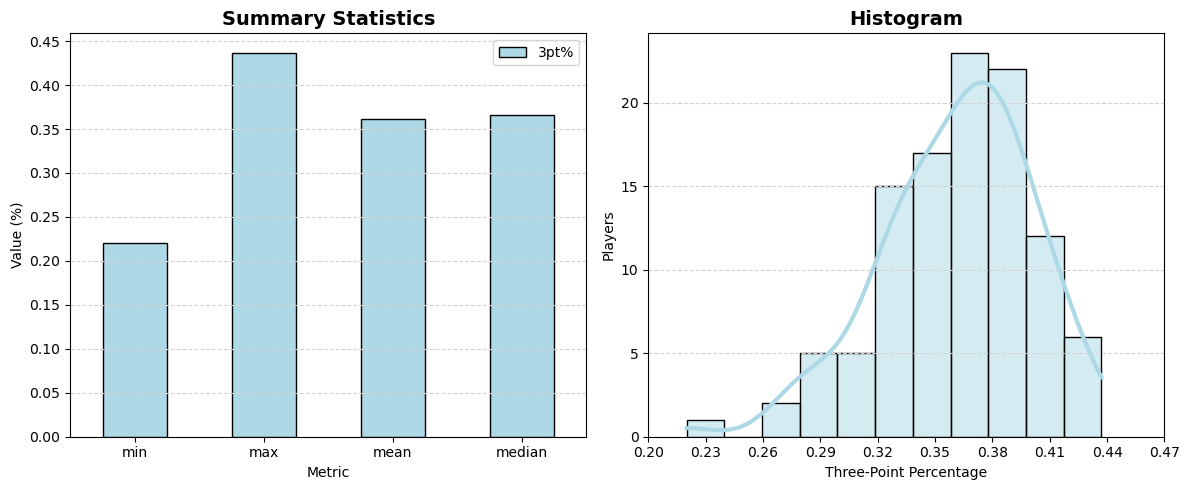

,3pt%
min,0.220000
max,0.437000
mean,0.361176
median,0.366500


In [6]:
# Summary statistics for outcome variable 'three_pct_season'
min_3pt = df['three_pct_season'].min()
max_3pt = df['three_pct_season'].max()
mean_3pt = df['three_pct_season'].mean()
median_3pt = df['three_pct_season'].median()

stats = {"min":min_3pt,
        "max":max_3pt,
        "mean":mean_3pt,
        "median":median_3pt}

stats_df = pd.DataFrame([stats]).transpose().rename(columns={0:'3pt%'})

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First plot - Summary Statistics of 'three_pct_season'
stats_df.plot(kind='bar', color='lightblue', edgecolor='black', ax=axes[0])
axes[0].grid(color='lightgrey', linestyle='--', axis='y')
axes[0].set_title("Summary Statistics", fontweight='bold', fontsize=14)
axes[0].set_ylabel("Value (%)")
axes[0].set_xlabel("Metric")
axes[0].set_xticklabels(stats_df.index, rotation=0)
axes[0].set_yticks(np.arange(0, 0.5, 0.05))

# Second plot - Histogram of 'three_pct_season'
sns.histplot(df['three_pct_season'], kde=True, color='lightblue', edgecolor='black', line_kws={'color': 'red', 'linewidth': 3}, ax=axes[1])
axes[1].grid(color='lightgrey', linestyle='--', axis='y')
axes[1].set_title("Histogram", fontweight='bold', fontsize=14)
axes[1].set_ylabel("Players")
axes[1].set_xlabel("Three-Point Percentage")
axes[1].set_xticks(np.arange(0.2, 0.5, 0.03))

# Adjust the layout
plt.tight_layout()
plt.show()

display(stats_df)

Due to the similar nature of many of the variables in the dataset, we may encounter issues of collinearity, so before any modeling, let's look into the correlations between the variables as well as the correlation between each variable and the outcome of interest (three_pct_season) in the DataFrame.

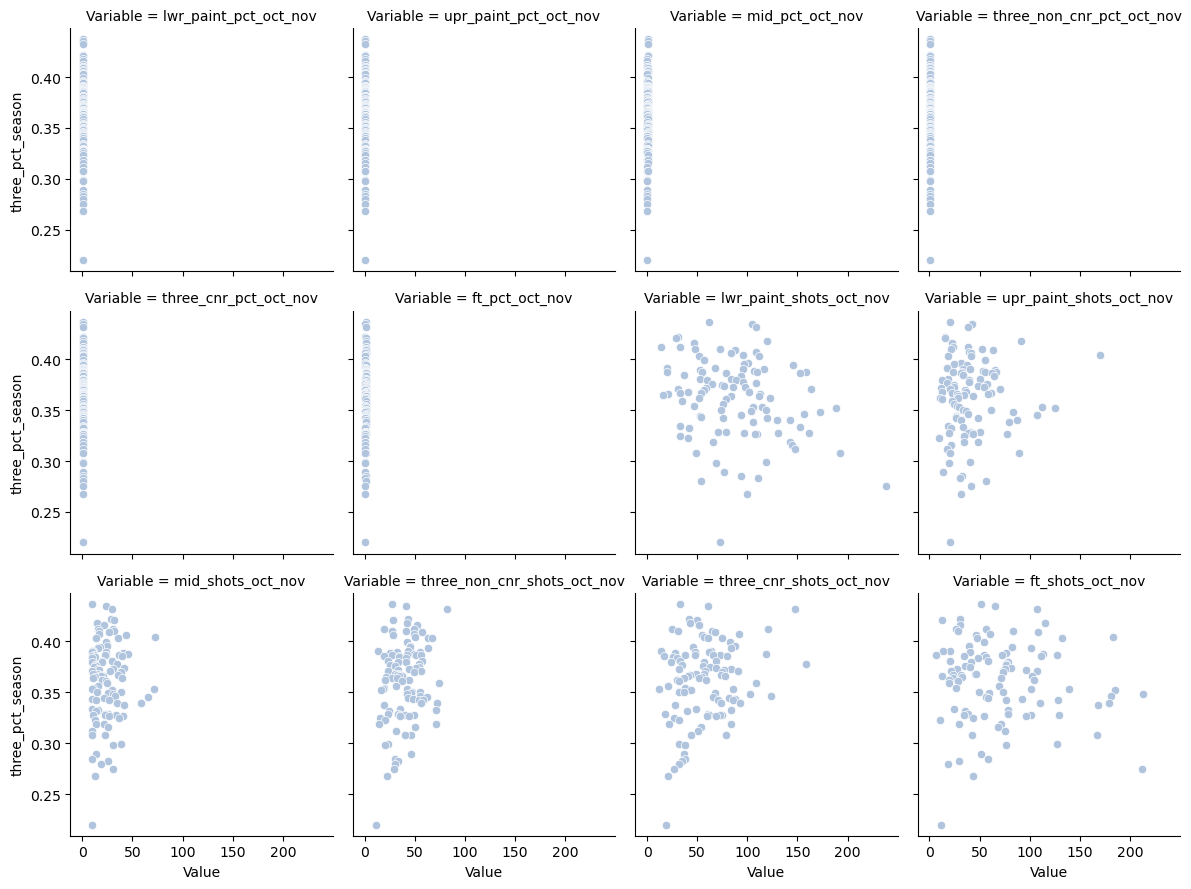

In [7]:
# Visualize the correlation between three_pct_season and each independent variable
variables = df.columns[2:]

# Reshape the DataFrame
df_long = df.melt(id_vars='three_pct_season', value_vars=variables, var_name='Variable', value_name='Value')

# Create a FacetGrid
grid = sns.FacetGrid(df_long, col='Variable', col_wrap=4)
grid.map(sns.scatterplot, 'Value', 'three_pct_season', color='lightsteelblue');

In [8]:
# Compute the correlation matrix for each variable vs 'three_pct_season'
corr_matrix = df.corr(numeric_only=True)

# Extract the correlations of all variables with 'three_pct_season'
corr = corr_matrix['three_pct_season']

# Display the correlations, sorted by absolute value descending
corr.abs().sort_values(ascending=False)


three_pct_season               1.000000
three_cnr_pct_oct_nov          0.508241
ft_pct_oct_nov                 0.347510
upr_paint_pct_oct_nov          0.290882
three_non_cnr_pct_oct_nov      0.271946
lwr_paint_shots_oct_nov        0.249411
three_non_cnr_shots_oct_nov    0.230933
three_cnr_shots_oct_nov        0.227750
mid_pct_oct_nov                0.164970
ft_shots_oct_nov               0.083265
mid_shots_oct_nov              0.068135
lwr_paint_pct_oct_nov          0.062074
upr_paint_shots_oct_nov        0.052534
Name: three_pct_season, dtype: float64

From the above, we see that 'three_cnr_pct_oct_nov', 'ft_pct_oct_nov', and 'upr_paint_pct_oct_nov' are the most highly-correlated with 'three_pct_season'. This indicates that these variables could be useful in predicting players' three-point percentages later on.

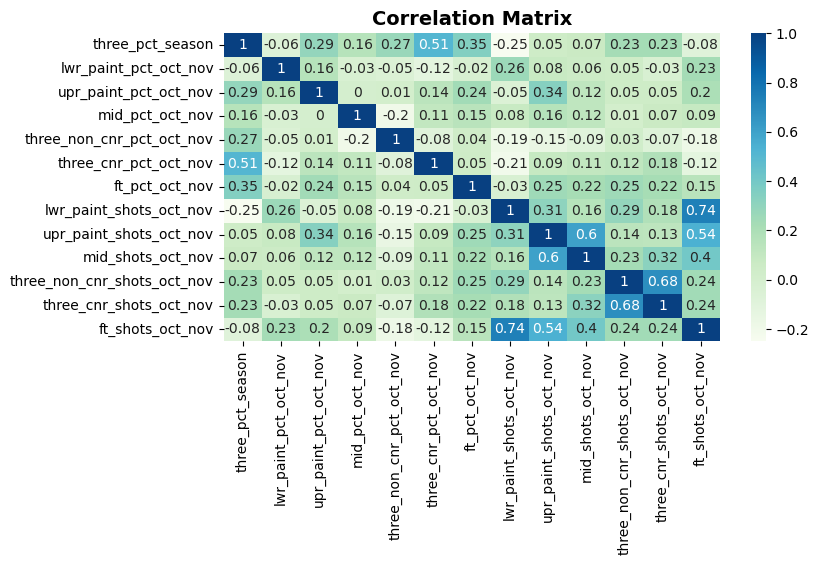

In [9]:
# Plotting the correlations with the target variable 'three_pct_season', and each feature variable against eachother
corrs = corr_matrix.round(2)
plt.figure(figsize=(8, 4))
sns.heatmap(corrs, annot=True, cmap='GnBu')
plt.title("Correlation Matrix", fontweight='bold', fontsize=14)
plt.show()

In [10]:
# Extract pairs with moderate-high correlations
threshold = 0.6
correlated_pairs = []
features_n = len(corrs.columns)

# Iterate over the correlation matrix
for i in range(features_n):
    for j in range(i):
        if abs(corrs.iloc[i, j]) > threshold:
            correlated_pairs.append((corrs.columns[i], corrs.columns[j], corrs.iloc[i, j]))

# Convert the list to a DataFrame for easier viewing
correlated_pairs = pd.DataFrame(correlated_pairs, columns=['feature_1', 'feature_2', 'corr'])

correlated_pairs

,feature_1,feature_2,corr
0,three_cnr_shots_oct_nov,three_non_cnr_shots_oct_nov,0.68
1,ft_shots_oct_nov,lwr_paint_shots_oct_nov,0.74


From the above correlation matrix, we see that there are moderate to strong, positive correlations between the following pairs of variables:
- three_cnr_shots_oct_nov & three_non_cnr_shots_oct_nov
- ft_shots_oct_nov & lwr_paint_shots_oct_nov	

We will need to be cautious of these relationships as we get into modeling.

## Feature Engineering

There are some features not explicitly included in the dataset but are easily attainable and potentially useful, such as made shots from each of the included ranges. We can compute these now and test them in a model later on.

In [12]:
# Feature engineering - made shots
df['lwr_paint_made_oct_nov'] = df['lwr_paint_shots_oct_nov'] * df['lwr_paint_pct_oct_nov']
df['upr_paint_made_oct_nov'] = df['upr_paint_shots_oct_nov'] * df['upr_paint_pct_oct_nov']
df['mid_paint_made_oct_nov'] = df['mid_shots_oct_nov'] * df['mid_pct_oct_nov']
df['three_non_cnr_made_oct_nov'] = df['three_non_cnr_shots_oct_nov'] * df['three_non_cnr_pct_oct_nov']
df['three_cnr_made_oct_nov'] = df['three_cnr_shots_oct_nov'] * df['three_cnr_pct_oct_nov']
df['ft_made_oct_nov'] = df['ft_shots_oct_nov'] * df['ft_pct_oct_nov']

df.sample(n=5)

,Name,three_pct_season,lwr_paint_pct_oct_nov,upr_paint_pct_oct_nov,mid_pct_oct_nov,three_non_cnr_pct_oct_nov,three_cnr_pct_oct_nov,ft_pct_oct_nov,lwr_paint_shots_oct_nov,upr_paint_shots_oct_nov,mid_shots_oct_nov,three_non_cnr_shots_oct_nov,three_cnr_shots_oct_nov,ft_shots_oct_nov,lwr_paint_made_oct_nov,upr_paint_made_oct_nov,mid_paint_made_oct_nov,three_non_cnr_made_oct_nov,three_cnr_made_oct_nov,ft_made_oct_nov
61,Caleb Martin,0.361,0.595,0.462,0.333,0.378,0.469,0.786,79,13,24,37,32,28,47.005,6.006,7.992,13.986,15.008,22.008
41,Cameron Payne,0.376,0.462,0.386,0.429,0.533,0.339,0.771,65,57,14,30,56,35,30.030,22.002,6.006,15.990,18.984,26.985
13,Jamal Murray,0.406,0.500,0.366,0.500,0.464,0.345,0.783,84,41,44,28,55,46,42.000,15.006,22.000,12.992,18.975,36.018
96,Russell Westbrook,0.312,0.466,0.278,0.300,0.355,0.294,0.707,148,18,10,31,51,75,68.968,5.004,3.000,11.005,14.994,53.025
48,Tyus Jones,0.371,0.581,0.500,0.200,0.391,0.362,0.636,31,70,10,23,58,22,18.011,35.000,2.000,8.993,20.996,13.992


## Modeling

In order to produce the most accurate predictions for each player's three-point percentage for the remainder of the season, we will fit the data to several statistical models and later on, compare their accuracy and choose the "best" model for this specific case.

Based on the EDA performed above and initial thoughts, it seems that a linear regression model is a good starting point. We saw several variables with moderate correlations with the dependent variable, three_pct_season. Also, logically it makes sense that as some of these features increase, so should their season-long 3 point percentage. For example, at first thought it makes sense that as a player's shooting percentage from the corner or upper-paint range increases, so should their 3-point and overall shooting percentage.

### Model A: Linear Regression

In [13]:
# Selecting the features and target variable (only including features explicity included in the provided dataset)
cols = ['lwr_paint_pct_oct_nov','upr_paint_pct_oct_nov', 'mid_pct_oct_nov', 'three_non_cnr_pct_oct_nov',
       'three_cnr_pct_oct_nov', 'ft_pct_oct_nov', 'lwr_paint_shots_oct_nov','upr_paint_shots_oct_nov', 
        'mid_shots_oct_nov','three_non_cnr_shots_oct_nov', 'three_cnr_shots_oct_nov','ft_shots_oct_nov']
X = df[cols]  # Features
y = df['three_pct_season']  # Target 

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure the data was split as expected
print("Train data observations:", X_train.shape[0])
print("Test data observations:", X_test.shape[0])

Train data observations: 86
Test data observations: 22


In [14]:
# Define and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions with the Linear Regression Model
predictions_linear = linear_model.predict(X_test)

# Model evaluation for the Linear Regression Model
mse_linear = mean_squared_error(y_test, predictions_linear)
r2_linear = r2_score(y_test, predictions_linear)

print("Mean Squared Error:", mse_linear.round(decimals=4))
print("R-squared Score:", r2_linear.round(decimals=4))

Mean Squared Error: 0.0009
R-squared Score: 0.3991


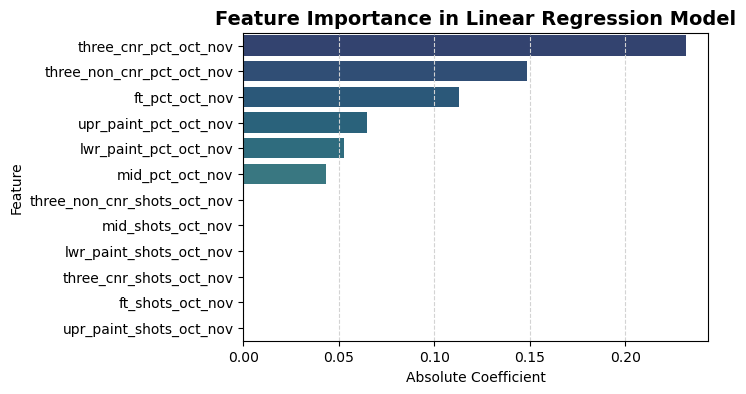

In [16]:
# Extracting coefficients
coefficients_linear = linear_model.coef_

# Pairing each feature with its coefficient
feature_coefficients_linear = pd.DataFrame({'feature': X.columns, 'coefficient': coefficients_linear})

# Sorting the features based on the absolute values of their coefficients
feature_coefficients_linear['coefficient_abs'] = feature_coefficients_linear['coefficient'].abs()
features_linear = feature_coefficients_linear.sort_values(by='coefficient_abs', ascending=False)

# Plot the features by importance 
plt.figure(figsize=(6, 4))
sns.barplot(data=features_linear, x='coefficient_abs', y='feature', palette='crest_r')
plt.grid(color='lightgrey', linestyle='--', axis='x')
plt.title('Feature Importance in Linear Regression Model', fontweight='bold', fontsize=14)
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.show()

We will use this Simple Linear Regression as a baseline for model performance going forward.

**Model Improvements**

In order to improve this baseline model, we will do a few things:

1. Account for potential issues with multicollinearity by:

        a. Dropping one variables from highly correlated pairs 
        b. Combining 2 highly correlated variables into one 

2. Feature Selection:

        a. Only include features with "pct"
        b. Only include features with some form of positive correlation with the dependent variable
        c. Include engineered features (made shots)

### Model B: Linear Regression with Dropped Variables
Dropping one variable from each pair of highly-correlated ones

In [17]:
# A. Dropping one variables from highly correlated pairs  
# Noteable correlated pairs as identified above 
correlated_pairs

# Drop the second variables in the correlated pairs 
drop_vars = list([correlated_pairs.iloc[0,1], correlated_pairs.iloc[1,1]])

# Split the new dataset into train and test
# Selecting the features and target variable
X_drop = df[cols].drop(drop_vars, axis=1)  # Features
y_drop = df['three_pct_season']  # Target 

# Splitting the data into training and testing sets
X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(X_drop, y_drop, test_size=0.2, random_state=42)

# Train the linear regression model on the new data
linear_model.fit(X_train_drop, y_train_drop)

# Make predictions with the Linear Regression Model
predictions_linear_drop = linear_model.predict(X_test_drop)

# Model evaluation for the Linear Regression Model
mse_linear_drop = mean_squared_error(y_test_drop, predictions_linear_drop)
r2_linear_drop = r2_score(y_test_drop, predictions_linear_drop)

print("Mean Squared Error:", mse_linear_drop.round(decimals=4))
print("R-squared Score:", r2_linear_drop.round(decimals=4))

Mean Squared Error: 0.0009
R-squared Score: 0.4119


### Model C: PCA-Transformed Linear Regression


In [18]:
# B. Combining 2 correlated variables
# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the PCA function which will be used for variable classification
pca = PCA(n_components=10) # reduce features to 10, knowing that 4 are highly correlated 
X_pca = pca.fit_transform(X_scaled)

# Splitting the PCA-transformed data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train the linear model on the PCA-transformed data 
linear_model.fit(X_train_pca, y_train_pca)

# Make predictions with the Linear Regression Model
predictions_linear_pca = linear_model.predict(X_test_pca)

# Model evaluation for the Linear Regression Model
mse_linear_pca = mean_squared_error(y_test_pca, predictions_linear_pca)
r2_linear_pca = r2_score(y_test_pca, predictions_linear_pca)

print("Mean Squared Error:", mse_linear_pca.round(decimals=4))
print("R-squared Score:", r2_linear_pca.round(decimals=4))

Mean Squared Error: 0.0009
R-squared Score: 0.4093


### Model D: Pct-Only Features Linear Regression

In [19]:
# Extracting column names that contain 'pct'
pct_cols = [col for col in df.columns if 'pct' in col]
pct_cols = pct_cols[1:]

X_pct = df[pct_cols] # Features

# Splitting the data into training and testing sets
X_train_pct, X_test_pct, y_train_pct, y_test_pct = train_test_split(X_pct, y, test_size=0.2, random_state=42)

# Train the model on the new data
linear_model.fit(X_train_pct, y_train_pct)

# Make predictions with the Linear Regression Model
predictions_linear_pct = linear_model.predict(X_test_pct)

# Model evaluation for the Linear Regression Model
mse_linear_pct = mean_squared_error(y_test_pct, predictions_linear_pct)
r2_linear_pct = r2_score(y_test_pct, predictions_linear_pct)

print("Mean Squared Error:", mse_linear_pct.round(decimals=4))
print("R-squared Score:", r2_linear_pct.round(decimals=4))

Mean Squared Error: 0.0008
R-squared Score: 0.4456


### Model E: Positive-Relation Only Features Linear Regression

In [28]:
# B. Linear Model with somewhat-related features 
corr_cols = list(corr[corr > 0.1].index)
corr_cols = corr_cols[1:]

X_corr = df[corr_cols] # Features

# Splitting the data into training and testing sets
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(X_corr, y, test_size=0.2, random_state=42)

# Train the model on the new data
linear_model.fit(X_train_corr, y_train_corr)

# Make predictions with the Linear Regression Model
predictions_linear_corr = linear_model.predict(X_test_corr)

# Model evaluation for the Linear Regression Model
mse_linear_corr = mean_squared_error(y_test_corr, predictions_linear_corr)
r2_linear_corr = r2_score(y_test_corr, predictions_linear_corr)

print("Mean Squared Error:", mse_linear_corr.round(decimals=4))
print("R-squared Score:", r2_linear_corr.round(decimals=4))

Mean Squared Error: 0.0007
R-squared Score: 0.5064


### Model F: Engineered-Feature Linear Regression - Made Shots

In [21]:
# C. Linear Model with Made Shots
all_cols = ['lwr_paint_pct_oct_nov', 'upr_paint_pct_oct_nov', 'mid_pct_oct_nov','three_non_cnr_pct_oct_nov', 
        'three_cnr_pct_oct_nov', 'ft_pct_oct_nov','lwr_paint_shots_oct_nov', 'upr_paint_shots_oct_nov',
        'mid_shots_oct_nov', 'three_non_cnr_shots_oct_nov','three_cnr_shots_oct_nov', 'ft_shots_oct_nov', 
        'lwr_paint_made_oct_nov','upr_paint_made_oct_nov', 'mid_paint_made_oct_nov','three_non_cnr_made_oct_nov', 
        'three_cnr_made_oct_nov','ft_made_oct_nov']
X_shots = df[all_cols]  # Features
y_shots = df['three_pct_season']  # Target 

# Splitting the data into training and testing sets
X_train_shots, X_test_shots, y_train_shots, y_test_shots = train_test_split(X_shots, y_shots, test_size=0.2, random_state=42)

# Train the model on the new data
linear_model.fit(X_train_shots, y_train_shots)

# Make predictions with the Linear Regression Model
predictions_linear_shots = linear_model.predict(X_test_shots)

# Model evaluation for the Linear Regression Model
mse_linear_shots = mean_squared_error(y_test_shots, predictions_linear_shots)
r2_linear_shots = r2_score(y_test_shots, predictions_linear_shots)

print("Mean Squared Error:", mse_linear_shots.round(decimals=4))
print("R-squared Score:", r2_linear_shots.round(decimals=4))

Mean Squared Error: 0.001
R-squared Score: 0.3077


## Model Selection & Evaluation

Based on all of the above models, we will choose our "champion" based on the R-square value. We will select the model with the highest R-square, and for purposes of this project, the highest accuracy.

In [24]:
models = {
    "A. Simple Linear": r2_linear.round(decimals=4),
    "B. Linear Dropped": r2_linear_drop.round(decimals=4),
    "C. PCA-Transformed": r2_linear_pca.round(decimals=4),
    "D. Percentage Features": r2_linear_pct.round(decimals=4),
    "E. Positive-Correlation Features": r2_linear_corr.round(decimals=4),
    "F. Feature-Engineered": r2_linear_shots.round(decimals=4),
}

# Convert to DataFrame and reset index
models_df = pd.DataFrame(list(models.items()), columns=['Model', 'R-Square'])
models_df.sort_values(by='R-Square', ascending=False)

,Model,R-Square
4,E. Positive-Correlation Features,0.5064
3,D. Percentage Features,0.4456
1,B. Linear Dropped,0.4119
2,C. PCA-Transformed,0.4093
0,A. Simple Linear,0.3991
5,F. Feature-Engineered,0.3077


It appears that the best model is the Linear Regression Model that only included features with some form of positive relationship/correlation with our dependent variable, three_pct_season. The R-square of 0.51 indicates that this model is only accounting for about 51% of the variance, or only getting us about 51% of the way to prefectly predicting players' full-season three-point percentages. 

We can now visualize which columns hold the highest importance in this model.

In [29]:
# Extract coefficients 
coefficients = linear_model.coef_
feature_coefficients = pd.DataFrame({'feature': X_train_corr.columns, 'coefficient': coefficients})
features = feature_coefficients.sort_values(by='coefficient', ascending=False)
features

,feature,coefficient
3,three_cnr_pct_oct_nov,0.249571
2,three_non_cnr_pct_oct_nov,0.159694
4,ft_pct_oct_nov,0.110573
0,upr_paint_pct_oct_nov,0.071404
1,mid_pct_oct_nov,0.034479
5,three_non_cnr_shots_oct_nov,0.000204
6,three_cnr_shots_oct_nov,0.000081


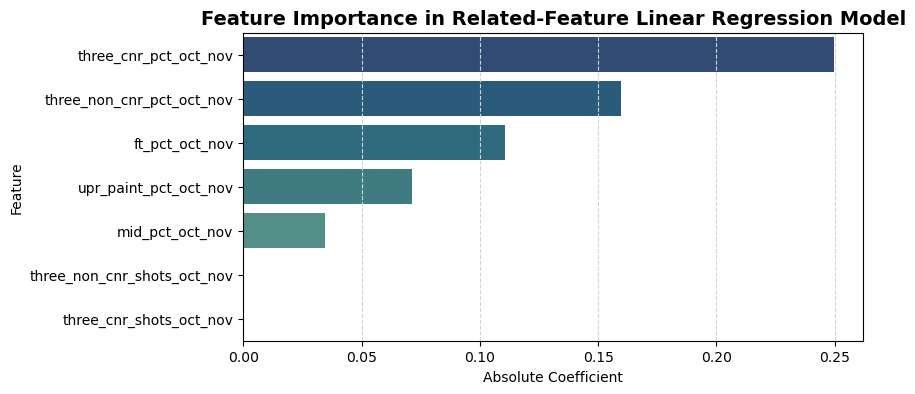

In [30]:
# Plot the features by importance 
plt.figure(figsize=(8, 4))
sns.barplot(data=features, x='coefficient', y='feature', palette='crest_r')
plt.grid(color='lightgrey', linestyle='--', axis='x')
plt.title('Feature Importance in Related-Feature Linear Regression Model', fontweight='bold', fontsize=14)
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.show()

,3pt%
min,0.318647
max,0.428374
mean,0.366932
median,0.369092


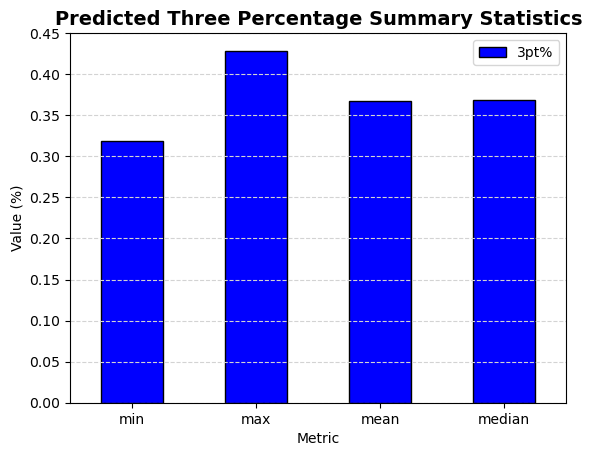

In [33]:
# Summary statistics for predicted outcome variable 'three_pct_season'
prediction_df = pd.DataFrame(predictions_linear_corr, columns=['predicted_three_pct_season'])

min_3pt = prediction_df['predicted_three_pct_season'].min()
max_3pt = prediction_df['predicted_three_pct_season'].max()
mean_3pt = prediction_df['predicted_three_pct_season'].mean()
median_3pt = prediction_df['predicted_three_pct_season'].median()

stats = {"min":min_3pt,
        "max":max_3pt,
        "mean":mean_3pt,
        "median":median_3pt}

stats_df = pd.DataFrame([stats]).transpose().rename(columns={0:'3pt%'})

# Graph for Summary Statistics of predicted 'three_pct_season'
stats_df.plot(kind='bar', color='blue', edgecolor='black')
plt.grid(color='lightgrey', linestyle='--', axis='y')
plt.title("Predicted Three Percentage Summary Statistics", fontweight='bold', fontsize=14)
plt.ylabel("Value (%)")
plt.xlabel("Metric")
plt.xticks(rotation=0)
plt.yticks(np.arange(0, 0.5, 0.05));

display(stats_df)

The summary metrics from the predictions are pretty close to the summary metrics found from the actual data for three_pct_season, showing that the model's predictions are indeed plausible.

In [32]:
# Reset index on the test set to align with the predictions DataFrame
X_test_corr_reset = X_test_corr.reset_index(drop=True)
y_test_corr_reset = y_test_corr.reset_index(drop=True)

# Combine the test inputs, actual target values, and predictions
combined_df = pd.concat([X_test_corr_reset, y_test_corr_reset, prediction_df], axis=1)
combined_df = combined_df.rename(columns={y_test_corr.name: 'three_pct_season'})

# Join this back to the initial DataFrame with player names 
full_df = combined_df.merge(df, how='left')

# Extract player projections 
full_df[['Name','predicted_three_pct_season', 'three_pct_season']].sort_values(by='predicted_three_pct_season', ascending=False)

,Name,predicted_three_pct_season,three_pct_season
12,Malcolm Brogdon,0.428374,0.437
4,Malik Beasley,0.402283,0.359
9,Bojan Bogdanovic,0.399224,0.409
6,AJ Griffin,0.389037,0.387
1,Patrick Williams,0.387497,0.410
2,Jevon Carter,0.386318,0.421
19,Brook Lopez,0.380301,0.375
14,Andrew Wiggins,0.379889,0.396
20,Tyrese Haliburton,0.378278,0.407
7,Bobby Portis,0.370320,0.373


As we can see above, many of the projected three point percentages are relatively close (within a few percentage points) of the true values. We can observe that within this group of players, the one with the highest actual three_pct_season was Malcolm Brogdon, and he is also the player with the highest predicted three_pct_season value, which is a positive sign.

## Model Improvement & Potential Next Steps

The most obvious way to improve the model would be to use a larger data set, both in terms of rows and columns. Modeling and making predictions with only 108 data points, or in this case, players, is not ideal and certainly, uding data on every player in the league over the last several seasons would allow for better and more accurate projections. Additionally, other information such as player's historic three-point and overall shooting percentages, positions, and other statistics would also likely enable better predictions. Another approach could be to apply some transformations to the data, or hyper-parameter tune the random forest or decision tree models for better accuracy. With more time and resources, this analysis could be improved to better project NBA players' three-point percentages.

**Resources**

For initial research and inspiration:
- https://www.researchgate.net/publication/333157905_Analysis_of_NBA_Players_and_Shot_Prediction_Using_Random_Forest_and_XGBoost_Models

- https://towardsdatascience.com/predicting-the-probability-of-scoring-a-basket-in-the-nba-using-gradient-boosted-trees-c157390fb17

- https://medium.com/@ammasanaswar/nba-player-stats-predicting-regular-season-and-postseason-ppg-55b71cc7a9b8

- https://www.kaggle.com/code/amirhosseinmirzaie/nba-players-scored-points-prediction

*Used ChatGPT (GPT4) for trouble shooting and minor sense checks*